<a href="https://colab.research.google.com/github/leanluo-a/fine-tuning-all/blob/main/C%26A_pilot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Generate the text (modeled after Culbertson & Adger 2014, PNAS) that will be used to fine-tune the model

In [27]:
import random

random.seed(123)

N = ["cat", "dog", "book"]
ADJ = ["beautiful", "blue", "good"]
NUM = ["one", "two", "three"]

def generate_sentences(n):
    return [
        f"Look! {random.choice(N)} {random.choice(ADJ)}! Look! {random.choice(N)} {random.choice(NUM)}!"
        for _ in range(n)
    ]

train_sentences = generate_sentences(50)
with open("train.txt", "w", encoding="utf-8") as f:
    for s in train_sentences:
        f.write(s + "\n")

dev_sentences = generate_sentences(50)
with open("dev.txt", "w", encoding="utf-8") as f:
    for s in dev_sentences:
        f.write(s + "\n")


Download the fine-tuning script from huggingface

In [2]:
!wget https://raw.githubusercontent.com/huggingface/transformers/27c1b656cca75efa0cc414d3bf4e6aacf24829de/examples/run_lm_finetuning.py

--2026-01-04 19:28:18--  https://raw.githubusercontent.com/huggingface/transformers/27c1b656cca75efa0cc414d3bf4e6aacf24829de/examples/run_lm_finetuning.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31078 (30K) [text/plain]
Saving to: ‘run_lm_finetuning.py’

run_lm_finetuning.p 100%[===================>]  30.35K  --.-KB/s    in 0s      

2026-01-04 19:28:18 (176 MB/s) - ‘run_lm_finetuning.py’ saved [31078/31078]



In [3]:
!pip install transformers datasets accelerate evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.1 MB/s eta 0:00:00


In [4]:
import torch
from datasets import load_dataset, Dataset
from transformers import GPT2Tokenizer, GPT2LMHeadModel, Trainer, TrainingArguments, DataCollatorForLanguageModeling

In [5]:
print(f"CUDA available: {torch.cuda.is_available()}")

CUDA available: True


In [6]:
MODEL_NAME = "gpt2"
FILE_PATH = "train.txt"
VAL_FILE_PATH = "dev.txt"
OUTPUT_DIR = "./gpt2_all"
BATCH_SIZE = 8
EPOCHS = 3
LEARNING_RATE = 2e-5

In [28]:
dataset = load_dataset("text", data_files={"train": FILE_PATH, "valid": VAL_FILE_PATH})


Generating train split: 0 examples [00:00, ? examples/s]

Generating valid split: 0 examples [00:00, ? examples/s]

In [29]:
tokenizer = GPT2Tokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token

In [9]:
model = GPT2LMHeadModel.from_pretrained(MODEL_NAME)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [10]:
def tokenize_function(examples):
  return tokenizer(examples["text"], truncation=True, max_length=512)
tokenized_datasets = dataset.map(tokenize_function, batched=True, remove_columns=["text"])

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

In [30]:
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=False # mlm=False is for Causal LM (GPT-2 style)
)

# Define Training Arguments ---
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    overwrite_output_dir=True,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    save_steps=10_000,
    save_total_limit=2,
    prediction_loss_only=True,
    learning_rate=LEARNING_RATE,
    logging_steps=500,
    report_to="none",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
)

In [31]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["valid"]
)

In [32]:
print("\nStarting fine-tuning...")
trainer.train()
print("Fine-tuning complete!")

trainer.save_model(OUTPUT_DIR)
print(f"Model saved to {OUTPUT_DIR}")


Starting fine-tuning...
{'eval_loss': 0.8719417452812195, 'eval_runtime': 0.1045, 'eval_samples_per_second': 478.42, 'eval_steps_per_second': 66.979, 'epoch': 1.0}
{'eval_loss': 0.7225766181945801, 'eval_runtime': 0.1063, 'eval_samples_per_second': 470.49, 'eval_steps_per_second': 65.869, 'epoch': 2.0}
{'eval_loss': 0.6770820617675781, 'eval_runtime': 0.1065, 'eval_samples_per_second': 469.357, 'eval_steps_per_second': 65.71, 'epoch': 3.0}
{'train_runtime': 86.6311, 'train_samples_per_second': 1.731, 'train_steps_per_second': 0.242, 'train_loss': 1.1212645031156994, 'epoch': 3.0}
Fine-tuning complete!
Model saved to ./gpt2_all


Examine surprisal values

In [33]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [34]:
 !pip install minicons
 !pip install matplotlib
 !pip install scipy

In [35]:
import pandas as pd
import numpy as np
from minicons import scorer
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

model.eval()
tokenizer.pad_token = tokenizer.eos_token

def get_token_surprisal(text):
    inputs = tokenizer(text, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=-1)

    token_logps = []
    token_surprisals = []

    input_ids = inputs["input_ids"][0]
    # Start from the second token as the first token's prediction is not based on prior context within the input
    for t in range(len(input_ids) - 1):

        logp = torch.log_softmax(logits[0, t, :], dim=-1)[input_ids[t+1]]
        surprisal = -logp
        token_logps.append(logp.item())
        token_surprisals.append(surprisal.item())


    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    return tokens, [0.0] + token_logps, [0.0] + token_surprisals

In [36]:
N = ["cat", "dog", "book"]
NUM = ["one", "two", "three"]
ADJ = ["beautiful", "blue", "good"]

new_conditions = {
    "N+NUM+ADJ": [f"Look! {n} {num} {adj}!" for n in N for num in NUM for adj in ADJ],
    "N+ADJ+NUM": [f"Look! {n} {adj} {num}!" for n in N for adj in ADJ for num in NUM]
}



In [37]:
def token_to_word_level(tokens, token_surprisals):
    words = []
    word_surprisals = []
    current_word = ""
    current_surp = 0
    for tok, surp in zip(tokens, token_surprisals):
        if tok.startswith("Ġ") or tok in ["!", ".", ","]:
            if current_word:
                words.append(current_word)
                word_surprisals.append(current_surp)
            current_word = tok.lstrip("Ġ")
            current_surp = surp
        else:
            current_word += tok
            current_surp += surp
    if current_word:
        words.append(current_word)
        word_surprisals.append(current_surp)
    return words, word_surprisals


In [38]:
def get_token_and_sentence_surprisal(text):
    inputs = tokenizer(text, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=-1)

    token_logps = []
    token_surprisals = []
    for t, token_id in enumerate(inputs["input_ids"][0]):
        logp = torch.log(probs[0, t, token_id])
        surprisal = -logp
        token_logps.append(logp.item())
        token_surprisals.append(surprisal.item())

    sentence_surprisal = sum(token_surprisals)
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    return tokens, token_logps, token_surprisals, sentence_surprisal


In [39]:
all_data_new = []
sentence_level_new = []

for cond_name, sents in new_conditions.items():
    for sent in sents:
        tokens, logps, surps, sent_surp = get_token_and_sentence_surprisal(sent)
        words, word_surps = token_to_word_level(tokens, surps)

        # word-level
        for pos, (word, sp) in enumerate(zip(words, word_surps)):
            all_data_new.append({
                "condition": cond_name,
                "sentence": sent,
                "position": pos+1,
                "word": word,
                "surprisal": sp
            })

        # sentence-level
        sentence_level_new.append({
            "condition": cond_name,
            "sentence": sent,
            "sentence_surprisal": sent_surp
        })

df_word_new = pd.DataFrame(all_data_new)
df_sentence_new = pd.DataFrame(sentence_level_new)

/tmp/ipython-input-1822935568.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


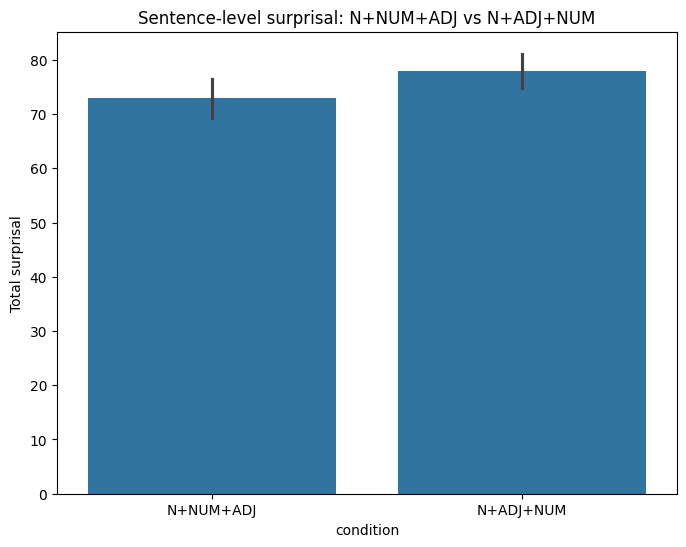

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.barplot(
    data=df_sentence_new,
    x="condition",
    y="sentence_surprisal",
    ci="sd"
)
plt.title("Sentence-level surprisal: N+NUM+ADJ vs N+ADJ+NUM")
plt.ylabel("Total surprisal")
plt.show()



In [24]:
for cond, group in df_sentence_new.groupby("condition"):
    print(f"\nCondition: {cond}")
    for i, row in group.iterrows():
        print(f"{row['sentence']} -> surprisal: {row['sentence_surprisal']:.3f}")


Condition: N+ADJ+NUM
Look! cat beautiful one! -> surprisal: 43.154
Look! cat beautiful two! -> surprisal: 41.218
Look! cat beautiful three! -> surprisal: 42.048
Look! cat blue one! -> surprisal: 43.640
Look! cat blue two! -> surprisal: 41.525
Look! cat blue three! -> surprisal: 42.149
Look! cat good one! -> surprisal: 42.823
Look! cat good two! -> surprisal: 40.613
Look! cat good three! -> surprisal: 41.641
Look! dog beautiful one! -> surprisal: 43.919
Look! dog beautiful two! -> surprisal: 42.090
Look! dog beautiful three! -> surprisal: 42.856
Look! dog blue one! -> surprisal: 44.853
Look! dog blue two! -> surprisal: 42.639
Look! dog blue three! -> surprisal: 43.205
Look! dog good one! -> surprisal: 43.335
Look! dog good two! -> surprisal: 41.539
Look! dog good three! -> surprisal: 42.597
Look! book beautiful one! -> surprisal: 43.791
Look! book beautiful two! -> surprisal: 42.026
Look! book beautiful three! -> surprisal: 43.134
Look! book blue one! -> surprisal: 45.449
Look! book bl